Notebook where I have computed the
 - usual dimension
 - the corrected dimension
 - the usual dimension with resampling of the analogs
 - the corrected dimension with resampling of the analogs
for the intermittent Lorenz 63 system ($\rho = 166.5$), for a gaussian random variable in 2 dimensions and for Paul's double-well system.

The usual dimension is each time computed for 1000 computation points and plotted for only 10 of them. On the other hand, the other versions of the dimensions are computed only for one chosen computation point, but for different values of the bandwidth.

The corrected dimension seems to effectively correct the dimension is most cases, while the dimensions via resampling have weird behaviors: for the intermittent Lorenz 63, the dimension are $\sim 3$ (maybe because the estimation of the density smoothes things out too much and creates a 3D structure while there is none). This does not happen for the other 2 systems, because the dimension in that case is the dimension of the state space

TO DO:
 - repeat for other systems, such as the classic Lorenz 63 ($\rho = 28$, will be maybe less interesting because there are less variations of the density) and for gaussian variables of higher dimensions (be careful that, for data for which the dimension is maximal, i.e. is the dimension of the state space, the estimation of the density works better, so it might be good to consider mostly cases where the dimension of the data is not maximal)
 - do the analysis for more points (check especially if all points have a dimension 2 in the intermittent Lorenz system)

In [1]:
%load_ext autoreload
%autoreload 2

# Intermittent Lorenz 63

In [2]:
import numpy as np
from numba import njit
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

In [3]:
@njit
def lorenz(t, X, sigma, beta, rho):
    u, v, w = X
    up = -sigma*(u - v)
    vp = rho*u - v - u*w
    wp = -beta*w + u*v
    return up, vp, wp

def sol_lorenz(tmax, n, t_trans, x0 = np.array([]), rho = 28):

    # tmax is the length of the trajectory and n total number of points
    
    # Lorenz parameters
    sigma, beta = 10, 8/3
    
    # if no initial conditions provided, fix some arbitrarily
    if len(x0) == 0:
        x0 = [0, 1, 1.05]

    # integrate on t_trans to be sure to be on the attractor and reset the initial condition
    soln = solve_ivp(lorenz, (0, t_trans), x0,
                     dense_output=False, args = (sigma, beta, rho))
    x0 = soln.y[:, -1]
    
    # Integrate the Lorenz equations
    soln = solve_ivp(lorenz, (0, tmax), x0, args=(sigma, beta, rho),
                     dense_output=True)
    
    # Interpolate solution onto the time grid t
    t = np.linspace(0, tmax, n)
    X = soln.sol(t).T

    return X

In [4]:
t_trans = 1000
tmax = 1e4
#tmax = 1e5
dt = 0.1
n = np.int64(tmax/dt)
rho = 166.5
pts = sol_lorenz(tmax, n, t_trans, rho = rho)

# Select computation points

In [5]:
np.random.seed(1)

comp_idxs = np.random.choice(len(pts), size = 1000, replace = False) # select random indices in the trajectories for the computation points
percentages = np.logspace(np.log10(100*5/len(pts)), np.log10(10), 20, dtype = np.float32) # exponentially spaced percentages
n_kept = percentages * len(pts)/100
print(f'number of analogs kept: {n_kept}')

number of analogs kept: [5.0000000e+00 7.4594784e+00 1.1128762e+01 1.6602951e+01 2.4769865e+01
 3.6954056e+01 5.5131592e+01 8.2250580e+01 1.2270927e+02 1.8306941e+02
 2.7312042e+02 4.0746719e+02 6.0789850e+02 9.0692102e+02 1.3530316e+03
 2.0185815e+03 3.0115132e+03 4.4928628e+03 6.7028823e+03 1.0000000e+04]


## Compute the usual dimension

In [6]:
from dimension_functions import comp_usual_dim

usual_dim = np.full((len(comp_idxs), len(percentages)), np.nan)
radii = np.full((len(comp_idxs), len(percentages)), np.nan)

for i, idx in enumerate(comp_idxs):
    radii[i], usual_dim[i] = comp_usual_dim(pts, pts[idx], percentages)

Text(0.5, 1.0, 'usual dimension as function of radius for different points')

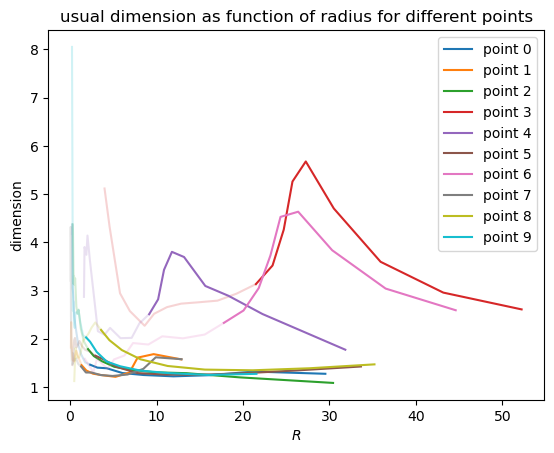

In [7]:
from dimension_functions import plot_dim

%matplotlib inline
for i in range(10):
    plot_dim(radii[i], usual_dim[i], n_kept, c = f'C{i}', label = f'point {i}')
plt.legend()
plt.title('usual dimension as function of radius for different points')

## Corrected dimension

In [8]:
# select one computation point/target and focus on that one
i = 4 # seems to be an interesting point
idx = comp_idxs[i]
i, idx

(4, np.int64(95321))

In [9]:
bandwidths = [0.01, 0.05, 0.1, 0.2, 0.5, 1, 2, 'scott', 'silverman'] # bandwidths of the kernel density estimator

In [10]:
from dimension_functions import comp_corrected_dim

radii, corrected_dim = comp_corrected_dim(pts, pts[idx], percentages, bandwidths)

100%|███████████████████████████████████████████| 20/20 [00:34<00:00,  1.74s/it]


Text(0.5, 1.0, 'corrected dimension as function of radius, for one point')

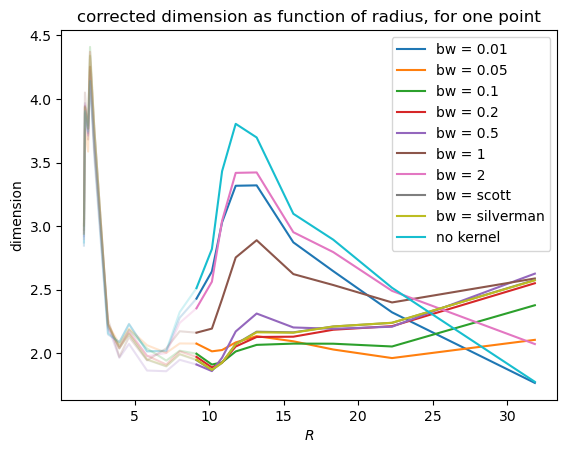

In [11]:
%matplotlib inline

for k, bw in enumerate(bandwidths):
    plot_dim(radii, corrected_dim[:, k], n_kept, label = f'bw = {bw}', c = f'C{k}')

plot_dim(radii, usual_dim[i], n_kept, label = 'no kernel', c = f'C{k + 1}')
plt.legend()
plt.title('corrected dimension as function of radius, for one point')

In [12]:
# check the attractor around the computation point to understand what is captured by the corrected dimension
'''
%matplotlib qt
fig = plt.figure()
ax = fig.add_subplot(projection="3d")


dist = np.linalg.norm(pts - pts[idx], axis = 1)
sel = dist<=radii[-1]
#sel = dist<=5
analogs = pts[sel]

ax.scatter(analogs[:, 0], analogs[:, 1], analogs[:, 2], alpha = 0.1)
ax.scatter(pts[idx, 0], pts[idx, 1], pts[idx, 2])
'''

'\n%matplotlib qt\nfig = plt.figure()\nax = fig.add_subplot(projection="3d")\n\n\ndist = np.linalg.norm(pts - pts[idx], axis = 1)\nsel = dist<=radii[-1]\n#sel = dist<=5\nanalogs = pts[sel]\n\nax.scatter(analogs[:, 0], analogs[:, 1], analogs[:, 2], alpha = 0.1)\nax.scatter(pts[idx, 0], pts[idx, 1], pts[idx, 2])\n'

## Usual dimension from resampled analogs

If the density of points around $\zeta$ is well estimated, one can draw a lot of points from this distribution, and then estimate the dimension based on these drawn points. It has the advantage that one can use a lot of points even for very small radii.

In [13]:
from dimension_functions import comp_dim_resampling

new_samples = len(pts)

resampled_radii, usual_dim_resampling = comp_dim_resampling(pts, pts[idx], percentages, new_samples, bandwidths)

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 35.12it/s]


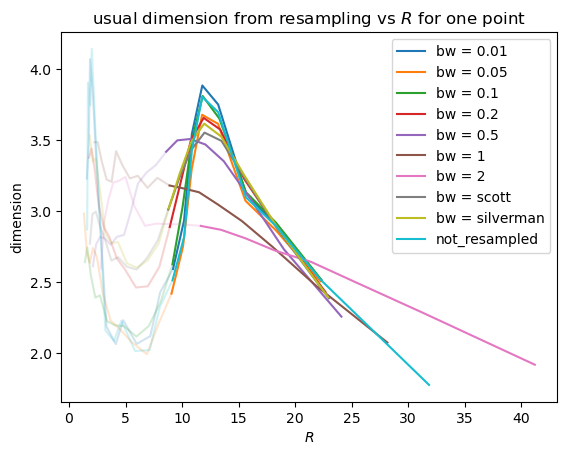

In [14]:
%matplotlib inline

for k, bw in enumerate(bandwidths):
    # there seems to be a problem with the last radius
    plot_dim(resampled_radii[:-1, k], usual_dim_resampling[:-1, k], n_kept, label = f'bw = {bw}', c = f'C{k}')

plot_dim(radii, usual_dim[i], n_kept, label = 'not_resampled', c = f'C{k + 1}')

plt.title('usual dimension from resampling vs $R$ for one point')
plt.legend()

## Corrected dimension from resampled analogs

In [15]:
from dimension_functions import comp_dim_resampling

new_samples = len(pts)

resampled_radii, corrected_dim_resampling = comp_dim_resampling(pts, pts[idx], percentages, new_samples, bandwidths, corrected = True)

100%|█████████████████████████████████████████████| 9/9 [04:20<00:00, 28.96s/it]


(1.5, 5.0)

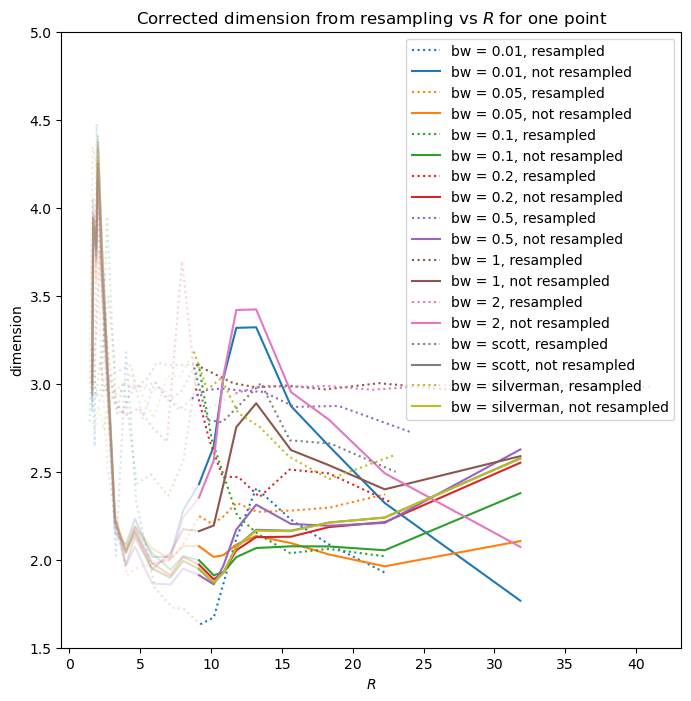

In [16]:
%matplotlib inline

fig = plt.figure(figsize = (8, 8))

for k, bw in enumerate(bandwidths):
    # there seems to be a problem with the last radius
    plot_dim(resampled_radii[:-1, k], corrected_dim_resampling[:-1, k], n_kept, label = f'bw = {bw}, resampled', c = f'C{k}', linestyle = 'dotted')

    plot_dim(radii, corrected_dim[:, k], n_kept, label = f'bw = {bw}, not resampled', c = f'C{k}')

plt.title('Corrected dimension from resampling vs $R$ for one point')
plt.legend()
plt.ylim((1.5, 5))

# Dimension of a random variable following a gaussian distribution

In [17]:
from scipy.stats import multivariate_normal

In [18]:
mean = np.array([0, 0])
cov = np.array([[1, 0],
                [0, 1]])
gaussian = multivariate_normal(mean = mean, cov = cov)

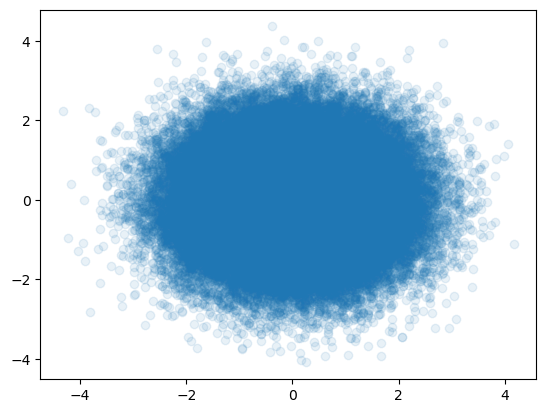

In [19]:
np.random.seed(1)
pts = gaussian.rvs(size = 100000)

%matplotlib inline
plt.scatter(pts[:, 0], pts[:, 1], alpha = 0.1)

In [20]:
# select computation points

np.random.seed(1)

comp_idxs = np.random.choice(len(pts), size = 100, replace = False) # select random indices in the trajectories for the computation points
percentages = np.logspace(np.log10(100*5/len(pts)), np.log10(10), 20, dtype = np.float32) # exponentially spaced percentages
n_kept = np.floor(percentages * len(pts)/100).astype(np.int64)
print(f'points kept in the fits: {n_kept}')

points kept in the fits: [    5     7    11    16    24    36    55    82   122   183   273   407
   607   906  1353  2018  3011  4492  6702 10000]


## Usual dimension

In [21]:
usual_dim = np.full((len(comp_idxs), len(percentages)), np.nan)
radii = np.full((len(comp_idxs), len(percentages)), np.nan)

for i, idx in enumerate(comp_idxs):
    radii[i], usual_dim[i] = comp_usual_dim(pts, pts[idx], percentages)

Text(0.5, 1.0, 'usual dimension for different points')

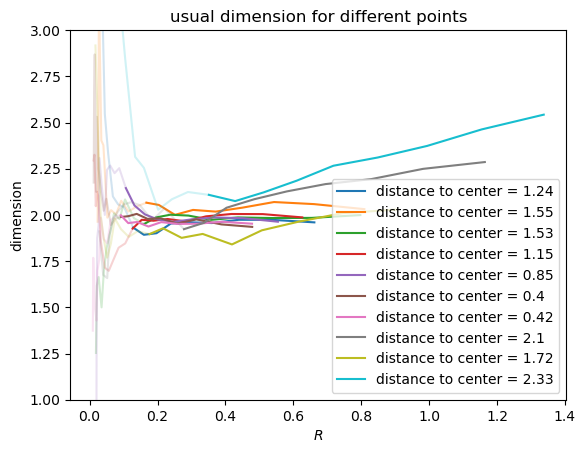

In [22]:
for i in range(10):
    plot_dim(radii[i], usual_dim[i], n_kept, label = f'distance to center = {np.round(np.linalg.norm(pts[comp_idxs[i]]), 2)}', c = f'C{i}')
plt.ylim((1, 3))
plt.legend()

plt.title('usual dimension for different points')

## Corrected dimension

In [23]:
bandwidths = [0.01, 0.05, 0.1, 0.2, 0.5, 1, 2, 'scott', 'silverman'] # bandwidths of the kernel density estimator

In [24]:
i = 9
idx = comp_idxs[i]
np.linalg.norm(pts[idx]) # this point is quite far from the center

np.float64(2.3278065409984943)

In [25]:
from dimension_functions import comp_corrected_dim

radii, corrected_dim = comp_corrected_dim(pts, pts[idx], percentages, bandwidths)

100%|███████████████████████████████████████████| 20/20 [00:31<00:00,  1.59s/it]


(1.4967707407910829, 3.0)

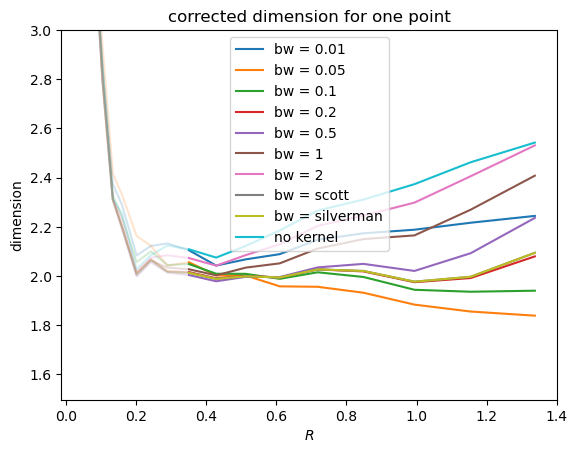

In [26]:
%matplotlib inline
for k, bw in enumerate(bandwidths):
    plot_dim(radii, corrected_dim[:, k], n_kept, label = f'bw = {bw}', c = f'C{k}')
plot_dim(radii, usual_dim[i], n_kept, label = 'no kernel', c = f'C{k + 1}')
plt.legend()
plt.title('corrected dimension for one point')
plt.ylim(top = 3)

## Usual dimension from resampled analogs

In [27]:
from dimension_functions import comp_dim_resampling

new_samples = len(pts)

resampled_radii, usual_dim_resampling = comp_dim_resampling(pts, pts[idx], percentages, new_samples, bandwidths)

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 41.41it/s]


(1.316473586949845, 3.0)

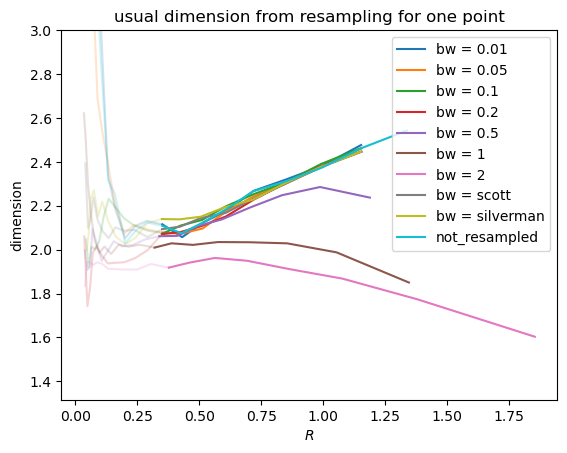

In [28]:
%matplotlib inline

for k, bw in enumerate(bandwidths):
    # there seems to be a problem with the last radius
    plot_dim(resampled_radii[:-1, k], usual_dim_resampling[:-1, k], n_kept, label = f'bw = {bw}', c = f'C{k}')

plot_dim(radii, usual_dim[i], n_kept, label = 'not_resampled', c = f'C{k + 1}')

plt.legend()

plt.title('usual dimension from resampling for one point')
plt.ylim(top = 3)

## Corrected dimension from resampled analogs

In [29]:
from dimension_functions import comp_dim_resampling

new_samples = len(pts)

resampled_radii, corrected_dim_resampling = comp_dim_resampling(pts, pts[idx], percentages, new_samples, bandwidths, corrected = True)

100%|█████████████████████████████████████████████| 9/9 [04:11<00:00, 27.96s/it]


(1.1268612615313078, 3.0)

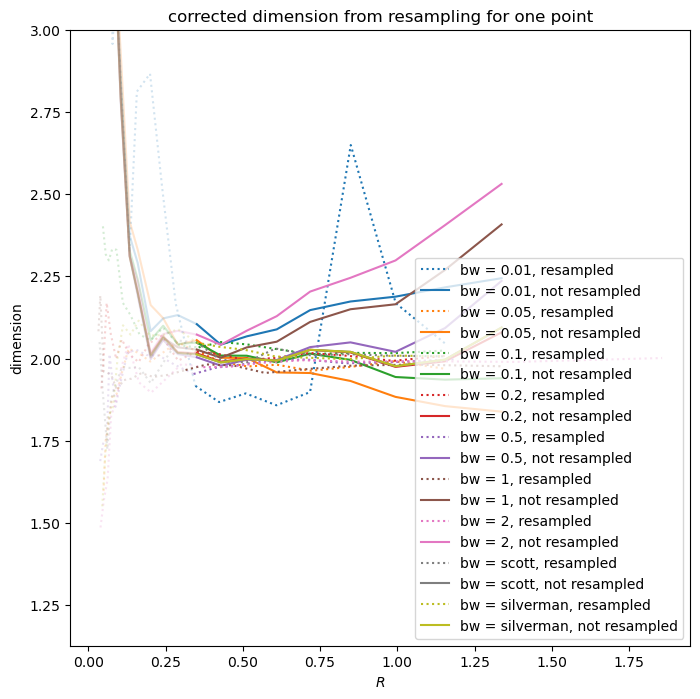

In [30]:
%matplotlib inline

fig = plt.figure(figsize = (8, 8))

for k, bw in enumerate(bandwidths):
    # there seems to be a problem with the last radius
    plot_dim(resampled_radii[:-1, k], corrected_dim_resampling[:-1, k], n_kept, label = f'bw = {bw}, resampled', c = f'C{k}', linestyle = 'dotted')

    plot_dim(radii, corrected_dim[:, k], n_kept, label = f'bw = {bw}, not resampled', c = f'C{k}')

plt.title('corrected dimension from resampling for one point')
plt.legend()
plt.ylim(top = 3)

# Paul's double-well system

In [31]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [32]:
c = 0
sig = 1.5

def drift(x):
    return 10*(1-x**2)*(x-c)

In [33]:
np.random.seed(1)

x0 = c # start at unstable equilibrium -> equal probability to jump in either one or another well
dt = .01
L = int(1000/dt)
#L = 10*int(50000/dt)
tt = dt*np.arange(L)
x = np.full(L,np.nan)
w = np.sqrt(dt)*np.random.randn(L)

x[0] = x0
for i in tqdm(range(L-1)):
    x[i+1] = x[i] + drift(x[i])*dt + sig*w[i]

100%|████████████████████████████████| 99999/99999 [00:00<00:00, 1348195.14it/s]


In [34]:
pts = x

In [35]:
# select comp_idxs

np.random.seed(1)

comp_idxs = np.random.choice(len(pts), size = 1000, replace = False) # select random indices in the trajectories for the computation points
percentages = np.logspace(np.log10(100*5/len(pts)), np.log10(10), 20, dtype = np.float32) # exponentially spaced percentages
n_kept = percentages * len(pts)/100
print(f'number of analogs kept: {n_kept}')

number of analogs kept: [5.0000000e+00 7.4594784e+00 1.1128762e+01 1.6602951e+01 2.4769865e+01
 3.6954056e+01 5.5131592e+01 8.2250580e+01 1.2270927e+02 1.8306941e+02
 2.7312042e+02 4.0746719e+02 6.0789850e+02 9.0692102e+02 1.3530316e+03
 2.0185815e+03 3.0115132e+03 4.4928628e+03 6.7028823e+03 1.0000000e+04]


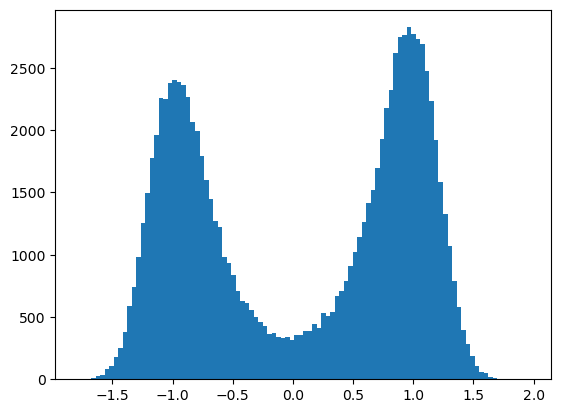

In [36]:
plt.hist(x, bins = 100)
plt.show()

## Usual dimension

In [37]:
from dimension_functions import comp_usual_dim

usual_dim = np.full((len(comp_idxs), len(percentages)), np.nan)
radii = np.full((len(comp_idxs), len(percentages)), np.nan)

for i, idx in tqdm(enumerate(comp_idxs)):
    radii[i], usual_dim[i] = comp_usual_dim(pts, pts[idx], percentages, coord_axis = None)

1000it [00:02, 411.71it/s]


Text(0.5, 1.0, 'usual dimension for different points')

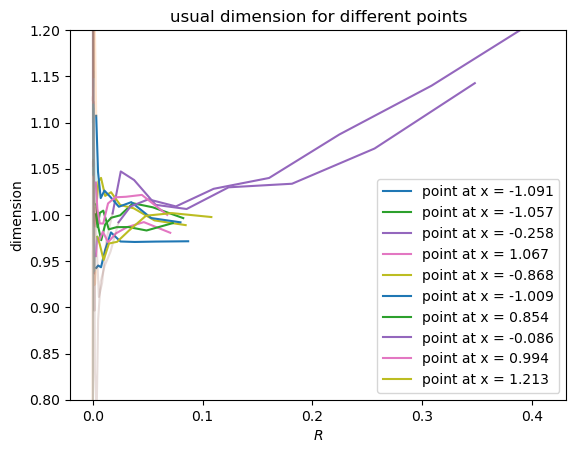

In [38]:
%matplotlib inline
for i in range(10):
    plot_dim(radii[i], usual_dim[i], n_kept, label = f'point at x = {np.round(pts[comp_idxs[i]], 3)}')
plt.legend()
plt.ylim((0.8, 1.2))

plt.title('usual dimension for different points')

## Corrected dimension

In [39]:
# select one computation point/target and focus on that one
i = 7 # seems to be an interesting point
idx = comp_idxs[i]
pts[idx]

np.float64(-0.08607436855741915)

In [40]:
bandwidths = [0.01, 0.05, 0.1, 0.2, 0.5, 1, 2, 'scott', 'silverman'] # bandwidths of the kernel density estimator

In [41]:
from dimension_functions import comp_corrected_dim

radii, corrected_dim = comp_corrected_dim(pts, pts[idx], percentages, bandwidths, coord_axis = None)

100%|███████████████████████████████████████████| 20/20 [00:28<00:00,  1.42s/it]


(0.7, 1.5)

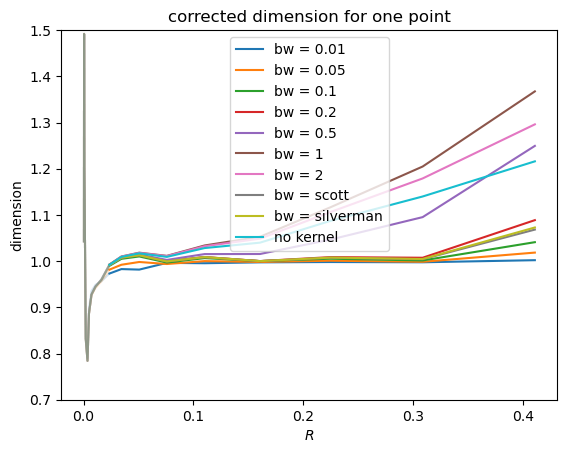

In [42]:
%matplotlib inline
for k, bw in enumerate(bandwidths):
    plot_dim(radii, corrected_dim[:, k], n_kept, label = f'bw = {bw}', c = f'C{k}')
plot_dim(radii, usual_dim[i], n_kept, label = 'no kernel', c = f'C{k + 1}')
plt.legend()
plt.title('corrected dimension for one point')
plt.ylim((0.7, 1.5))

## Usual dimension from resampled analogs

In [43]:
from dimension_functions import comp_dim_resampling

new_samples = len(pts)

resampled_radii, usual_dim_resampling = comp_dim_resampling(pts, pts[idx], percentages, new_samples, bandwidths, coord_axis = None)

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 28.67it/s]


(0.8, 1.3)

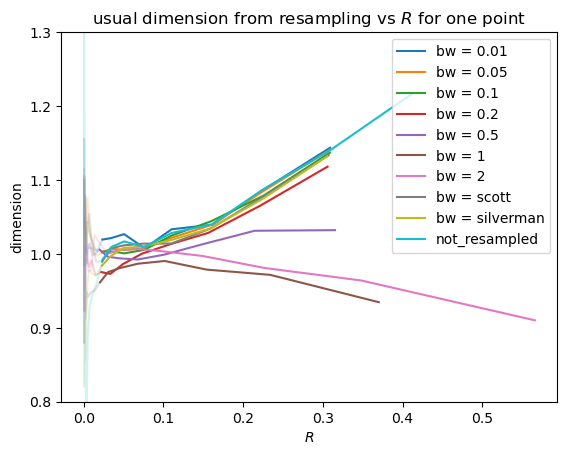

In [44]:
%matplotlib inline

for k, bw in enumerate(bandwidths):
    # there seems to be a problem with the last radius
    plot_dim(resampled_radii[:-1, k], usual_dim_resampling[:-1, k], n_kept, label = f'bw = {bw}', c = f'C{k}')

plot_dim(radii, usual_dim[i], n_kept, label = 'not_resampled', c = f'C{k + 1}')

plt.title('usual dimension from resampling vs $R$ for one point')

plt.legend()
plt.ylim((0.8, 1.3))

## Corrected dimension from resampled analogs

In [ ]:
from dimension_functions import comp_dim_resampling

new_samples = len(pts)

resampled_radii, corrected_dim_resampling = comp_dim_resampling(pts, pts[idx], percentages, new_samples, bandwidths, corrected = True, coord_axis = None)

 44%|████████████████████                         | 4/9 [02:14<02:32, 30.48s/it]

In [ ]:
%matplotlib inline

fig = plt.figure(figsize = (8, 8))

for k, bw in enumerate(bandwidths):
    # there seems to be a problem with the last radius
    plot_dim(resampled_radii[:-1, k], corrected_dim_resampling[:-1, k], n_kept, label = f'bw = {bw}, resampled', c = f'C{k}', linestyle = 'dotted')

    plot_dim(radii, corrected_dim[:, k], n_kept, label = f'bw = {bw}, not resampled', c = f'C{k}')

plt.title('Corrected dimension from resampling vs $R$ for one point')
plt.legend()